In [1]:
using Revise
using LinearAlgebra
using SparseArrays
using Pkg
using DelayDiffEq 
using Plots
using BenchmarkTools

In [2]:
using OpenQuantumSystems

┌ Info: Precompiling OpenQuantumSystems [90e503ea-487f-4e8e-81fe-8dcc9db25ac5]
└ @ Base loading.jl:1342


In [12]:
D(op1::Array, op2::Array) = abs(norm(op1 - op2))
D(x1::StateVector, x2::StateVector) = norm(x2 - x1)
D(op1::AbstractOperator, op2::AbstractOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))
D(op1::AbstractSuperOperator, op2::AbstractSuperOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))

HR = 0.01
shift = (2.0 * HR)
modes = [Mode(180., shift)]
mols = [
        Molecule([Mode(180., shift)], 3, [12500., 12710.]),
        Molecule([Mode(180., shift)], 3, [12500., 12690.])
    ]

aggCore = AggregateCore(mols)
for mol_i in 2:aggCore.molCount
    aggCore.coupling[mol_i, mol_i+1] = 200
    aggCore.coupling[mol_i+1, mol_i] = 200
end
agg = setupAggregate(aggCore)
aggCore = agg.core
aggTools = agg.tools
aggOperators = agg.operators

Ham_sys = agg.operators.Ham_sys
Ham_bath = agg.operators.Ham_bath
Ham_S = agg.operators.Ham_S
Ham_B = agg.operators.Ham_B
Ham_I = agg.operators.Ham_I
Ham_0 = agg.operators.Ham_0
Ham = agg.operators.Ham

basis = agg.tools.basis
indicesLen = agg.tools.bSize
indices = agg.tools.indices
indicesMap = agg.tools.indicesMap
FCFact = agg.tools.FCfactors
FCProd = agg.tools.FCproduct

Ham_0_lambda, Ham_0_S = eigen(Ham_0.data)
Ham_0_Sinv = inv(Ham_0_S)
Ham_0_lambda = diagm(Ham_0_lambda)

Ham_sys_lambda, Ham_sys_S = eigen(Ham_sys.data)
Ham_sys_Sinv = inv(Ham_sys_S)
Ham_sys_lambda = diagm(Ham_sys_lambda)
println("")

In [13]:
t_max = 0.1
t_count = 200
t0 = 0.
t_step = (t_max - t0) / (t_count)
tspan = [t0:t_step:t_max;]

T = 300
mu_array = [[2, 1]]
W0_1 = thermal_state(T, [[2, 1]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_2 = thermal_state(T, [[1, 2]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_3 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
W0_4 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
a1 = indicesMap[2][1]; a2 = indicesMap[2][end]
b1 = indicesMap[3][1]; b2 = indicesMap[3][end]
W0_3.data[a1:a2, b1:b2] = W0_2.data[b1:b2, b1:b2]
W0_4.data[b1:b2, a1:a2] = W0_2.data[b1:b2, b1:b2]
W0 = 0.8*W0_1 + 0.2*W0_2 #+ 0.1*W0_3 + 0.1*W0_4
W0 = DenseOperator(W0.basis_l, W0.basis_r, complex(W0.data))

# data = Matrix(Hermitian(rand(ComplexF64, indicesLen, indicesLen)))
# W0 = DenseOperator(basis, basis, data)
# normalize!(W0)

W0_bath = get_rho_bath(W0, aggCore, aggTools)
W0_bath = DenseOperator(W0_bath.basis_l, W0_bath.basis_r, complex(W0_bath.data))

rho0 = trace_bath(W0, aggCore, aggTools)
rho0 = DenseOperator(rho0.basis_l, rho0.basis_r, complex(rho0.data))

println("")

In [31]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 5
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60
using OpenQuantumSystems
@time _, rho_int_t = QME_sI_ansatz_const(
    W0,
    tspan,
    agg;
    reltol = 1e-4,
    abstol = 1e-4,
    int_reltol = 1e-5,
    int_abstol = 1e-5,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5()),
)

 10.895738 seconds (17.79 M allocations: 1.989 GiB, 3.21% gc time, 2.62% compilation time)


([0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045  …  0.0955, 0.096, 0.0965, 0.097, 0.0975, 0.098, 0.0985, 0.099, 0.0995, 0.1], Operator{GenericBasis{Vector{Int64}}, GenericBasis{Vector{Int64}}, Matrix{ComplexF64}}[Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im       0.0+0.0im      0.0+0.0im
 0.0+0.0im  0.799839+0.0im      0.0+0.0im
 0.0+0.0im       0.0+0.0im  0.19996+0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im           0.0+0.0im                   0.0+0.0im
 0.0+0.0im      0.799839-0.0im          -3.93979e-11-3.60731e-10im
 0.0+0.0im  -3.93979e-11+3.60731e-10im       0.19996+0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im           0.0+0.0im                  0.0+0.0im
 0.0+0.0im      0.799839+0.0im         -1.33672e-10-2.85993e-9im
 0.0+0.0im  -1.33672e-10+2.85993e-9im       0.19996-0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im           0.0+0.0im                 0.0+0.0im
 0.0+0.0im      0.799839-0.0im        -2.65963e-1

In [32]:
W_t_exact = zeros(ComplexF64, length(tspan), agg.tools.bSize, agg.tools.bSize)
t_i = 0

for t_i in 1:length(tspan)
    t = tspan[t_i]
    U_op = evolutionOperator(Ham, t)
    W = U_op * W0 * U_op'
    U_0_op = evolutionOperator(Ham_0, t)
    W = U_0_op' * W * U_0_op
    W_t_exact[t_i, :, :] = W.data
end

1 0.0
2 4.0357518218509656e-13
3 1.8886309663350954e-13
4 1.628593825039901e-9
5 6.669332354435027e-9
6 1.2684568092010422e-8
7 1.7728581327070296e-8
8 2.0524549593191515e-8
9 2.0464539384299977e-8
10 1.755777051582787e-8
11 1.2340851334372963e-8
12 5.848553640359259e-9
13 2.9866351630709815e-9
14 8.628631129792738e-9
15 1.3364571804200747e-8
16 1.594792390211462e-8
17 1.615295637588478e-8
18 1.4325800916016748e-8
19 1.1388174385301009e-8
20 8.817288147902045e-9
21 6.821736236031291e-9
22 8.028927394476905e-9
23 3.55236903502894e-8
24 7.154550227812391e-8
25 1.1218883300900979e-7
26 1.5396829607421028e-7
27 1.9395181578511233e-7
28 2.2986639092407542e-7
29 2.601633542336406e-7
30 2.8403814196948313e-7
31 3.0140408334791897e-7
32 3.1282405577580527e-7
33 3.194075920575019e-7
34 3.226826733963635e-7
35 3.2444980579561736e-7
36 3.2662041879196387e-7
37 3.310358663350643e-7
38 3.39265757636071e-7
39 3.524034002545379e-7
40 3.709022047366084e-7
41 3.9450301774229137e-7
42 4.222724148507123e

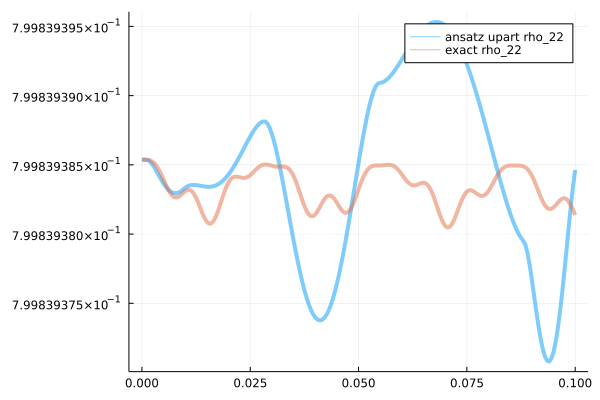

In [33]:

elLen = aggCore.molCount
rho_t = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t_exact = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)

for t_i in 1:length(tspan)
    rho_t[t_i, :, :] = rho_int_t[t_i].data
    rho_t_exact[t_i, :, :] = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    println(t_i, " ", D(rho_t[t_i, :, :], rho_t_exact[t_i, :, :]))
end

plot(tspan, real(rho_t[:, 2, 2]), label="ansatz upart rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t_exact[:, 2, 2]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)

(27, 27)
1 0.0
2 4.035573356682944e-13
3 1.8885240488401517e-13
4 1.6285937659383688e-9
5 6.669332325445069e-9
6 1.2684568150195663e-8
7 1.772858133810639e-8
8 2.0524549489473366e-8
9 2.0464539409100913e-8
10 1.7557770570388602e-8
11 1.2340851254426236e-8
12 5.84855377250088e-9
13 2.9866352038158264e-9
14 8.628631108153402e-9
15 1.336457177181257e-8
16 1.594792390421534e-8
17 1.6152956378684064e-8
18 1.4325800878828479e-8
19 1.138817441929226e-8
20 8.817288150315625e-9
21 6.821736185190486e-9
22 8.028927392069808e-9
23 3.552369038817673e-8
24 7.154550228944276e-8
25 1.121888330685333e-7
26 1.5396829611899832e-7
27 1.9395181579229983e-7
28 2.298663909559315e-7
29 2.601633543110298e-7
30 2.840381419046299e-7
31 3.014040833151103e-7
32 3.1282405577295823e-7
33 3.1940759203444605e-7
34 3.2268267336416803e-7
35 3.2444980583561664e-7
36 3.266204187664766e-7
37 3.310358663525895e-7
38 3.392657576492828e-7
39 3.524034002516109e-7
40 3.7090220476323166e-7
41 3.9450301763841025e-7
42 4.222724148

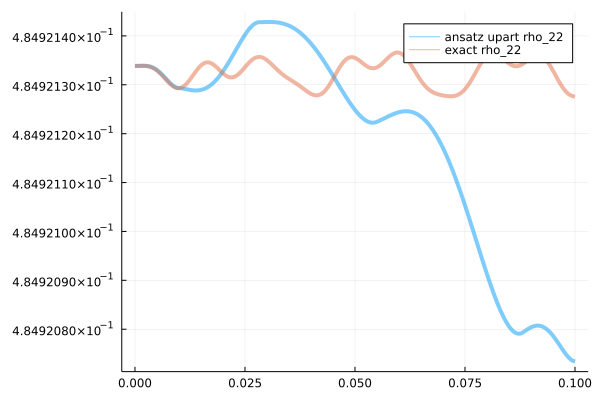

In [34]:
elLen = aggCore.molCount
rho_t = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t_exact = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
println(size(Ham_0_Sinv))
for t_i in 1:length(tspan)
    t = tspan[t_i]
    U_op = evolutionOperator(Ham_sys, t)
    rho_t[t_i, :, :] = Ham_sys_Sinv * (U_op').data * rho_int_t[t_i].data * U_op.data * Ham_sys_S
    rho = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    rho_t_exact[t_i, :, :] = Ham_sys_Sinv * (U_op').data * rho * U_op.data * Ham_sys_S
    println(t_i, " ", D(rho_t[t_i, :, :], rho_t_exact[t_i, :, :]))
end

plot(tspan, real(rho_t[:, 1, 1]), label="ansatz upart rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t_exact[:, 1, 1]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)

In [27]:
using OpenQuantumSystems
include("test_master_ansatz.jl")


Test Summary: |
master ansatz | No tests


Test.DefaultTestSet("master ansatz", Any[], 0, false, false)

In [71]:
names = [
    "test_operators_dense.jl",
    "test_superoperators.jl",
    "test_metrics.jl",
    "test_molecules.jl",
    "test_aggregateCore.jl",
    "test_aggregateTools.jl",
    "test_aggregateOperators.jl",
    "test_aggregate.jl",
    "test_evolution.jl",
    "test_schroedinger.jl",
    "test_liouville.jl",
    "test_interaction_picture.jl",
    "test_master_exact.jl",
    "test_trace.jl",
    "test_initial_state.jl",
    "test_memory_kernel.jl",
    "test_master_ansatz.jl",
]

for name in names
    include(name)
end

Test Summary:   | Pass  Total
operators dense |    6      6
Test Summary:  | Pass  Total
superoperators |    2      2
Test Summary: | Pass  Total
metrics       |   19     19
Test Summary: | Pass  Total
molecules     |   20     20
Test Summary: | Pass  Total
aggregateCore |   14     14
Test Summary:  | Pass  Total
aggregateTools |   12     12
Test Summary:      | Pass  Total
aggregateOperators |    7      7
Test Summary: | Pass  Total
aggregate     |    3      3
Test Summary: | Pass  Total
evolution     |   54     54
Test Summary: | Pass  Total
schroedinger  |   25     25
Test Summary: | Pass  Total
liouville     |   33     33
Test Summary:       | Pass  Total
interaction picture |   12     12
Test Summary: |
master        | No tests
Test Summary: | Pass  Total
trace         |   41     41
Test Summary: | Pass  Total
initial state |    8      8
Test Summary: | Pass  Total
memory kernel |   51     51
Test Summary: |
master ansatz | No tests
